In [40]:
# .py 파일 수정사항 바로 반영하기 위한 옵션
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import json
import pandas as pd
import os
from pprint import pprint
from data_cleaner import data_cleaner

In [42]:
# pandas 전체 행 출력 옵션
pd.set_option('display.max_rows', None)

In [43]:
with open('../data/raw/raw_data.json') as f:
    data_json = json.load(f)    # data_json은 '곡 제목_가수 이름' 이 key값인 dict 형태

len(data_json)

4686

In [44]:
# 개별 곡의 데이터 형태 보기
pd.DataFrame(data_json['08베이식 (Feat. 염따 & punchnello)_베이식 (Basick)']).head(3)

,datetime,cumulative_listeners,cumulative_streams
0,2021-11-27 13,8721,10612
1,2021-11-27 14,17463,23321
2,2021-11-27 15,25386,35886


# Data Cleaning

따로 발매되었지만 제목과 가수가 같은 곡들이 존재한다. (이미 발매했지만 리패키지 앨범에 다시 수록한 경우 등)

이런 경우, 별개의 곡에 대한 정보가 한 데이터에 혼재되어 나오기 때문에 데이터를 사용할 수가 없다

해당 곡들의 제목을 저장해두고 학습데이터 구축 시 포함되지 않도록 해준다.

In [45]:
corrupt_data = []

for song in data_json.keys():
    df = pd.DataFrame(data_json[song])

    # unique한 시간의 개수와 전체 데이터의 개수가 다르면 같은 시간대에 2곡이 차트에 올라왔다는 뜻 -> 정보가 혼합됨
    if len(df.datetime.unique()) != df.shape[0]:
        corrupt_data.append(song)

pprint(corrupt_data)

['어떻게 이별까지 사랑하겠어, 널 사랑하는 거지_AKMU (악뮤)',
 '작은 것들을 위한 시 (Boy With Luv) (Feat. Halsey)_방탄소년단',
 '노을_다비치',
 'Flower_윤미래',
 '우연인 듯 운명_10CM',
 '다시 난, 여기_백예린 (Yerin Baek)',
 "TOUCHIN'_강다니엘",
 '둘만의 세상으로 가_Crush',
 '마음을 드려요_아이유 (IU)',
 '그때 그 아인_김필',
 '나보다 더 사랑해요_김호중',
 'How You Like That_BLACKPINK',
 'Dynamite_방탄소년단',
 'Ice Cream (With Selena Gomez)_BLACKPINK',
 'Girls Girls Girls_GOT7 (갓세븐)',
 'PARANOIA_강다니엘',
 '멜로디_ASH ISLAND',
 'Butter_방탄소년단',
 '편의점_이찬원',
 'Dreams Come True_aespa']


# 학습데이터 만들기

사용 Feature: 시간별 평균 스트리밍 횟수의 변동성

* 시간별 평균 스트리밍 횟수를 사용하면 곡마다 사용자수가 천차만별이기 때문에 스케일도 안 맞고 스트리밍 횟수가 많은 곡들이 변화폭도 클 것이다
    
* 이러한 부분을 고려하여 normalize된 변동성을 척도로 사용한다: (현재 시각 평균 스트리밍 횟수 - 이전 시각 평균 스트리밍 횟수)/이전 시각 평균 스트리밍 횟수

시간별 평균 스트리밍 횟수의 변동성 계산

In [46]:
streams = []
need_checking = []

for song in data_json.keys():

    # 서로 다른 곡의 정보가 혼합된 데이터는 skip
    if song in corrupt_data:
        continue

    df = data_cleaner(pd.DataFrame(data_json[song]))    # df는 (date, hour, current_listeners)로 구성된 Dataframe

    # 0시~23시 중 특정 시간대에 대한 정보가 아예 없거나, 특정 시간대에 대한 표본이 10개(10일) 미만이라 너무 적은 경우 데이터를 버린다
    count = df.groupby('hour').agg({'date':'count'})
    if (count.shape[0] < 24) or (any(count.date < 10)):
        continue

    # 시간별 변동성 계산: (현재 시각 평균 정보 - 이전 시각 평균 정보)/이전 시각 평균 정보 -> 이전 시각의 정보로 나눠서 normalizing 함
    mean_df = df.groupby('hour').agg({'current_streams':'mean'})
    mean_df['variability'] = (mean_df['current_streams'] - mean_df['current_streams'].shift(1)) / mean_df['current_streams'].shift(1)
    mean_df.dropna(inplace=True)

    # 데이터 오류 검토 -> 변동성이 비자연스럽게 크면 데이터에 문제 있는지 확인 (기준은 변동성의 절대값이 2보다 큰 값이 존재할 시)
    if (mean_df['variability'].map(lambda x: not (abs(x) < 2))).any():
        print(f'Variability is too high!! {song}')
        need_checking.append([song, mean_df])   # 이상 데이터 있다면 데이터 확인해보기 위해 저장

    # index 바꾸기
    mean_df.set_index(pd.Index(str(i-1) + '시' + '~' + str(i) + '시' for i in range(1,24)), inplace=True)
    
    # transpose 하고 index 노래 이름으로 바꾸기
    mean_df = mean_df[['variability']].transpose()
    mean_df.set_index(pd.Index([song]), inplace=True)

    streams.append(mean_df)

Variability is too high!! 어떤X (What Type of X)_제시
Variability is too high!! 색안경 (STEREOTYPE)_STAYC (스테이씨)
Variability is too high!! Cold Blooded_제시


변동성 값이 과하게 큰 데이터가 이상치나 데이터 오류 아닌지 확인하기

-> 사람들이 활동을 시작하는 아침 시간에 변동성이 급등하는 것으로 큰 이상은 없어 보인다

In [47]:
for song, data in need_checking:
    print(song)
    print(data)
    print('-' * 50)

어떤X (What Type of X)_제시
         current_streams  variability
0시~1시        1612.272727    -0.280158
1시~2시        1114.454545    -0.308768
2시~3시         794.318182    -0.287258
3시~4시         574.181818    -0.277139
4시~5시         466.636364    -0.187302
5시~6시         560.227273     0.200565
6시~7시        1244.500000     1.221420
7시~8시        3751.125000     2.014162
8시~9시        5487.040000     0.462772
9시~10시       3836.031250    -0.300892
10시~11시      3758.375000    -0.020244
11시~12시      4029.303030     0.072086
12시~13시      4357.354839     0.081417
13시~14시      4612.000000     0.058440
14시~15시      4549.121212    -0.013634
15시~16시      4541.787879    -0.001612
16시~17시      4523.885714    -0.003942
17시~18시      5061.656250     0.118874
18시~19시      5733.156250     0.132664
19시~20시      4600.794118    -0.197511
20시~21시      4084.937500    -0.112123
21시~22시      3698.451613    -0.094612
22시~23시      3204.666667    -0.133511
--------------------------------------------------
색안경 (STEREOTY

In [48]:
# 학습데이터 개수
len(streams)

755

데이터 형태 확인

In [49]:
df_streams = pd.concat(streams)
df_streams.head(2)

,0시~1시,1시~2시,2시~3시,3시~4시,4시~5시,5시~6시,6시~7시,7시~8시,8시~9시,9시~10시,...,13시~14시,14시~15시,15시~16시,16시~17시,17시~18시,18시~19시,19시~20시,20시~21시,21시~22시,22시~23시
METEOR_창모 (CHANGMO),-0.158998,-0.235707,-0.208502,-0.192565,-0.130965,0.035388,0.615862,1.081598,0.272517,-0.181870,...,0.071129,0.025686,0.008512,0.011133,0.036625,0.067972,-0.123489,-0.116251,-0.138441,-0.124419
Psycho_Red Velvet (레드벨벳),-0.213678,-0.231851,-0.215881,-0.199363,-0.146071,0.013887,0.535579,1.129406,0.485418,-0.183293,...,0.058571,0.027523,0.012719,0.013552,0.044005,0.071401,-0.123025,-0.120268,-0.133228,-0.124301


데이터 저장

In [50]:
cleaned_data_path = '../data/cleaned'

if not os.path.exists(cleaned_data_path):
    os.mkdir(cleaned_data_path)

df_streams.to_csv(cleaned_data_path + "/streams.csv", encoding='utf-8-sig')

# 시각화

데이터셋에서 일부 데이터만 뽑아 시각화

In [51]:
import matplotlib.pyplot as plt
import matplotlib
import random

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

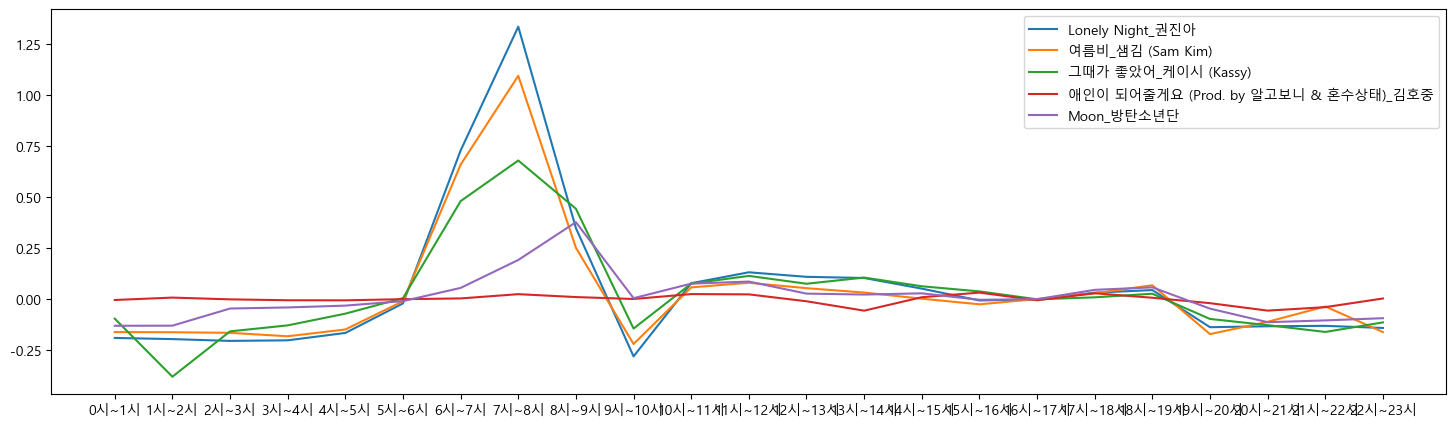

In [52]:
random.seed(1)
ind = random.sample(range(df_streams.shape[0]),5)

plt.figure(figsize=(18,5))

for i in ind:
    plt.plot(df_streams.iloc[i,:], label=df_streams.index[i]);

plt.legend();